# View Pic Du Midi Data


Read the spectra from Pic du Midi (2019).
The spectra has been reconstructed by Spectractor.
The Spectra in fits file has been converted into panda in
https://github.com/sylvielsstfr/SpectractorAnaAtm19/blob/master/ana_20190215_HD116405_Filtre_None/convertSpectraToPandas.py


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : September 22th 2020
- update : September 25th 2020 : cut tail for order 2



# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline


In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S

In [4]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [5]:
from scipy import interpolate

# Functions

In [6]:
def GetSpectra(inputdir,inputfiles):
    """
    GetSpectra(inputdir,inputfiles)
    
    input:
      - input directory
      - list of files
    
    return
      - list of dataframes
    """
    
   
    all_df = []
    idx=0
    for file in inputfiles:
        fullfilename=os.path.join(inputdir,file)
        
        df = pd.read_csv(fullfilename,index_col=0)
        spec = df["flux"].values
        specmax=spec.max()
        if specmax<1e-11:
            idx+=1
            continue
        #if idx>160 and idx<200:
        #    idx+=1
        #    continue
        
        all_df.append(df)
        idx+=1
        
    return all_df

In [7]:
def ConvertToImage(all_df,WLMIN=350,WLMAX=1100):
    """
    ConvertToImage(all_df,WLMIN=350,WLMAX=1100)
    
    
    """
    
    N=len(all_df)
    WL=np.arange(WLMIN,WLMAX+1)
    NWL=len(WL)
    
    mag_table=np.zeros((N,NWL))
    
    for idx in np.arange(N):
        df=all_df[idx]
        
        fcn = interpolate.interp1d(df.wavelength,df.mag,bounds_error=False,fill_value=(0,0))
        mag_table[idx,:]=fcn(WL) 
        
    return WL, mag_table
       

# Constants

# Initialisation

In [8]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [9]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2020-09-25 18:13:14,947 MacBook-Pro-de-admin.local __main__[64220] INFO LA time:09:13:14
2020-09-25 18:13:14,949 MacBook-Pro-de-admin.local __main__[64220] INFO NY time:12:13:14
2020-09-25 18:13:14,952 MacBook-Pro-de-admin.local __main__[64220] INFO London time:17:13:14
2020-09-25 18:13:14,954 MacBook-Pro-de-admin.local __main__[64220] INFO Paris time:18:13:14
2020-09-25 18:13:14,955 MacBook-Pro-de-admin.local __main__[64220] INFO ************************ START *********************


In [10]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [11]:
# config file
# --------------
configfile = "config/default.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2020-09-25 18:13:14,973 MacBook-Pro-de-admin.local __main__[64220] INFO Configuration file : config/default.ini


In [12]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2020-09-25 18:13:14,994 MacBook-Pro-de-admin.local __main__[64220] INFO 1) Configuration


In [13]:
config_section = config.sections()

In [14]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [15]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [16]:
msg=f" Object observed {target}"
logger.info(msg)

2020-09-25 18:13:15,046 MacBook-Pro-de-admin.local __main__[64220] INFO  Object observed HD116405


In [17]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

# input files

## sed

In [18]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))

In [19]:
sed_w=s0.wave/10
sed_f=s0.flux*10
sed_idx=np.where(np.logical_and(sed_w>350,sed_w<1100))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [20]:
sed_m=-2.5*np.log10(sed_f)

## data

In [21]:
all_files = os.listdir(inputdir)
sorted_files=sorted(all_files)


In [22]:
# search string
search_str="^"+f"{basefilename}.*csv$"

In [23]:
selected_files=[]
for file in sorted_files:
    if re.search(search_str,file):
        selected_files.append(file)

In [24]:
NBFILES=len(selected_files)

In [25]:
msg=f" Number of selected files is {NBFILES}"
logger.info(msg)

2020-09-25 18:13:15,197 MacBook-Pro-de-admin.local __main__[64220] INFO  Number of selected files is 347


In [26]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)

### Read all files

In [27]:
all_df=GetSpectra(inputdir,selected_files)

In [28]:
NBFILES=len(all_df)

In [29]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)

In [30]:
msg=f" Number of good spectra is {NBFILES}"
logger.info(msg)

2020-09-25 18:13:17,750 MacBook-Pro-de-admin.local __main__[64220] INFO  Number of good spectra is 345


(300.0, 1200.0)

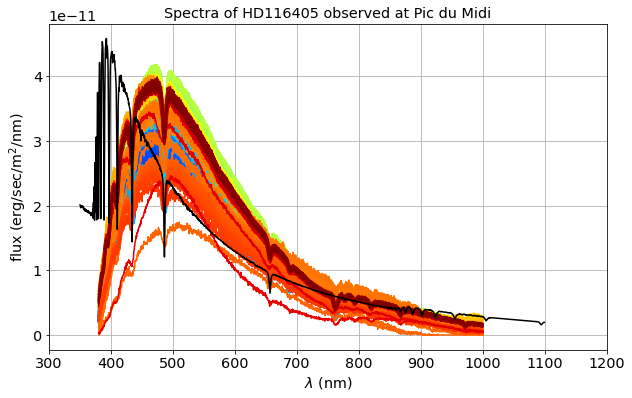

In [31]:
fig=plt.figure()
ax=fig.add_subplot(111)
for ifile in np.arange(NBFILES):
    the_df=all_df[ifile]

    ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Spectra of {target} observed at Pic du Midi"
ax.set_title(title)
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1200)

(25.0, 35.0)

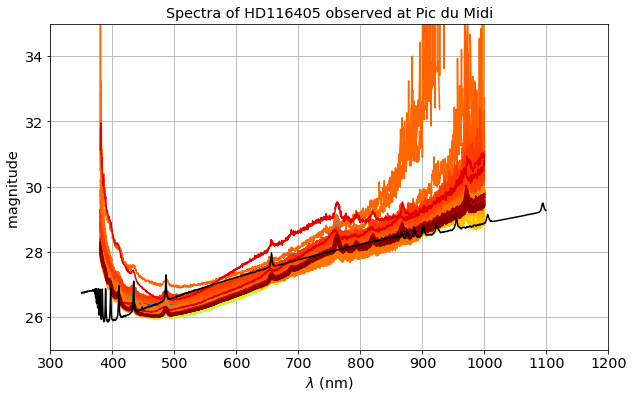

In [32]:
fig=plt.figure()
ax=fig.add_subplot(111)
for ifile in np.arange(NBFILES):
    the_df=the_df=all_df[ifile]

    ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Spectra of {target} observed at Pic du Midi"
ax.set_title(title)
ax.plot(sed_w,sed_m,'k-')
ax.set_xlim(300,1200)
ax.set_ylim(25,35)

# Convert into Mag table

In [33]:
WL,Mags= ConvertToImage(all_df,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL )

In [34]:
fcn_sed_mag0 = interpolate.interp1d(sed_w,sed_m,bounds_error=False,fill_value=(0,0))
sed_mag0 =fcn_sed_mag0(WL)

In [35]:
MagsRef=Mags-sed_mag0

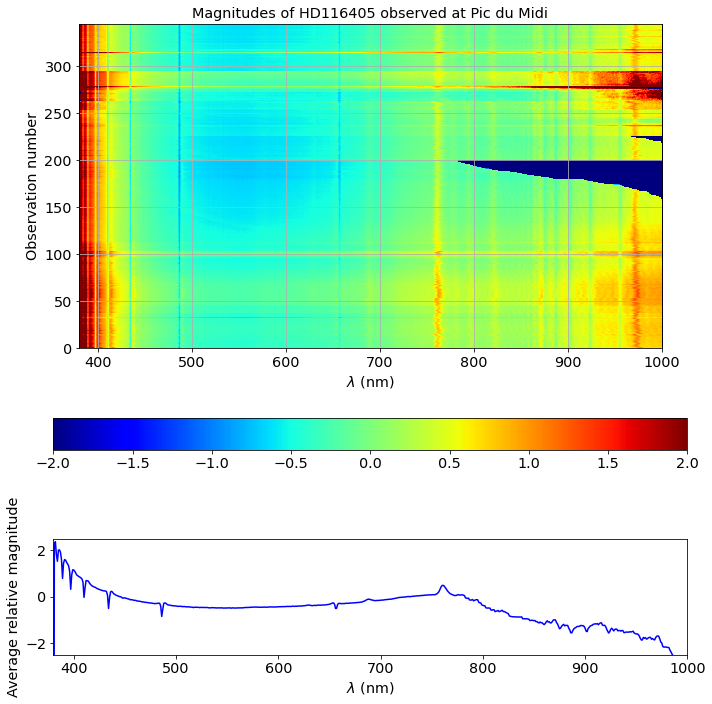

In [36]:
fig=plt.figure(figsize=(10,10))

gs = fig.add_gridspec(2, 1,height_ratios=[4,1])

ax1=fig.add_subplot(gs[0, :])

extent=(WL.min(),WL.max(),0,NBFILES)
norm = mpl.colors.Normalize(vmin=-2, vmax=2)
im=ax1.imshow(MagsRef,origin="lower",norm=norm,extent=extent,cmap="jet")
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), ax=ax1, orientation="horizontal" )
ax1.grid()
ax1.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("Observation number")
title=f"Magnitudes of {target} observed at Pic du Midi"
ax1.set_title(title)


ax2=fig.add_subplot(gs[1, :],sharex=ax1)

Y=np.average(MagsRef,axis=0)
ax2.plot(WL,Y,"b-")
ax2.set_ylim(-2.5,2.5)
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylabel("Average relative magnitude")
plt.tight_layout()

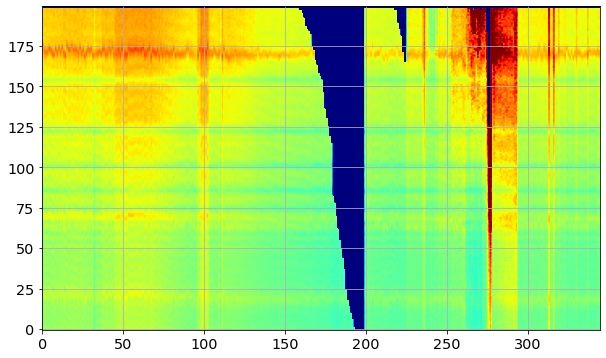

In [37]:
plt.imshow(MagsRef[:,-200:].T,origin="lower",norm=norm,cmap="jet")
plt.grid()

In [38]:
profileY=np.average(MagsRef[:,-200:],axis=1)

In [39]:
import mpld3
from mpld3 import plugins

In [ ]:
fig=plt.figure(figsize=(16,6))
ax=fig.add_subplot(111)
ax.plot(profileY,'b')
ax.grid()
#plt.show()

plugins.connect(fig, plugins.MousePosition(fontsize=14))

mpld3.show()


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [25/Sep/2020 18:13:22] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Sep/2020 18:13:22] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Sep/2020 18:13:22] "GET /mpld3.js HTTP/1.1" 200 -
